# User-Analyse

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import requests
import datetime
from IPython.display import HTML, display

sns.set()
pd.set_option('display.expand_frame_repr', False)

In [2]:
with open("api_token.txt") as f:
    api_token = f.read().strip()

URL = 'https://graph.facebook.com/v9.0/'

In [3]:
def get_all_pages(path, params, url = URL):
    uri = url + path
    output = []
    response = requests.get(uri, params=params)
    response.raise_for_status() # don't drop HTTP errors silently
    data = response.json()
    
    # no pages / data returned directly
    try:
        output += data['data']
    except KeyError:
        return data
    
    paging = data.get('paging')
    while paging:
        next_page = paging.get('cursors', {}).get('after')
        paging = None
        if next_page:
            params['after'] = next_page
            response = requests.get(uri, params=params)
            data = response.json()
            output = output + data['data']
            paging = data.get('paging')
    return output


def setupAxis(ax):
    ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%Y'))

In [4]:
parser=lambda ts: pd.Timestamp(ts).strftime('%Y-%m-%d')

people_cols = ["Datum", "Eingeladen", "Aktiviert", "Monatlich aktive", "Wöchentlich aktive", "Täglich aktive"]
df_people = pd.read_csv("../data/people.csv", index_col="Datum",
                        parse_dates=["Datum"], date_parser=parser,
                        usecols=[i for i in range(len(people_cols))],
                        names=people_cols, header=0)

content_cols = ["Datum", "Erstellte Posts", "Personen posteten", "Kommentare", "Personen kommentierten",
                "Reaktionen", "Personen reagierten", "Nachrichten", "Personen schrieben Nachricht"]
df_content = pd.read_csv("../data/content.csv", index_col="Datum",
                        parse_dates=["Datum"], date_parser=parser,
                        names=content_cols, header=0)

groups_cols = ["Datum", "Monatlich aktive", "Wöchentlich aktive", "Täglich aktive"]
df_groups = pd.read_csv("../data/groups.csv", index_col="Datum",
                        parse_dates=["Datum"], date_parser=parser,
                        names=groups_cols, header=0)

df_connections = pd.read_csv("../data/connections.csv", index_col="Datum",
                        parse_dates=["Datum"], date_parser=parser,
                        names=["Datum", "durchschn. Verbindungen"], header=0)

In [5]:
params = {'access_token': api_token, "fields" : "id, account_claim_time"}

df_members = pd.DataFrame(get_all_pages("/company/members", params))
df_members["account_claim_time"] = df_members["account_claim_time"].str[:-5]
df_members["1st_created_time"] = np.nan
df_members["diff_claim_1st"] = np.nan
df_members["interactions"] = np.nan
df_members["mean_interval_hours"] = np.nan

## Useraktivität

Ein paar wenige inaktive Mitglieder (bisher nur eingeladen oder deaktiviert):

In [6]:
df_members[df_members.account_claim_time.isna()]["id"]

86    100051634658582
87    100051719254485
Name: id, dtype: object

Wie zu sehen ist, ist sowohl die Zahl der eingeladenen Personen als auch die der aktivierten Accounts (es wird zwischen dem Status "eingeladen" und "Konto aktiviert" unterschieden.)
sehr nah bei einander annähernd stetig gestiegen. Dies bedeutet stetigen Zulauf mit zeitnaher Aktivierung
eines Accounts (wie auch weiter unten zu sehen ist).

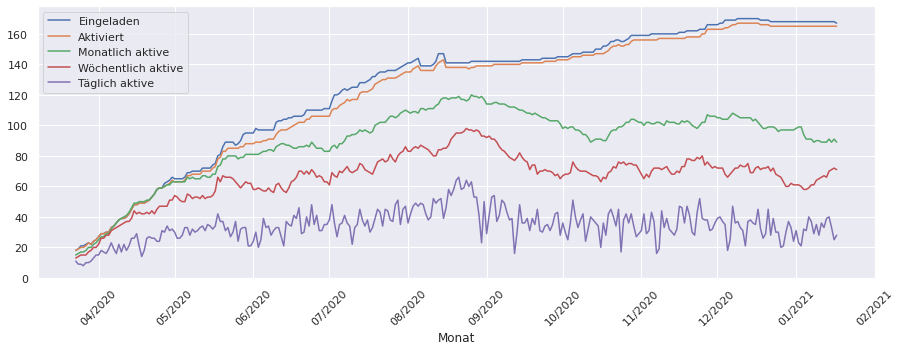

In [7]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

setupAxis(ax)

sns.lineplot(data=df_people, ax=ax)

for line in ax.lines:
    line.set_linestyle("-")

for line in ax.legend().get_lines():
    line.set_linestyle('-')

ax.set_ylabel("")
ax.set_xlabel("Monat")
ret = plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

**Dauer zwischen Anmeldung (bzw. Zeitpunkt, ab dem Interaktion möglich ist) und erster Interaktion, und durchschnittlicher Interaktionsrhythmus**

Als Anfangsdatum des Analysezeitraums haben wir den 23.3.20 gesetzt, kurz vor der Öffnung von Eigenleben als soziales Netzwerk.
Dauer zwischen Anmeldung und 1. Interaktion ist in Tagen.
Anzahl der Interaktionen = Anzahl der Elemente in der Userhistorie.
Der Rhythmus ist die durchschnittliche Zeit in Stunden von Interaktion zu Interaktion in der Historie eines Users.

In [8]:
# Here eigenleben started as public social network:
since_time = datetime.datetime.strptime("2020/03/23", "%Y/%m/%d")
since_time = datetime.datetime.timestamp(since_time)

In [9]:
params = {'access_token': api_token, "since": since_time}
hours_activity = {h : 0 for h in range(24)} 

df_active_members = df_members[df_members.account_claim_time.notna()]

for ix in df_active_members.index:
    user_id = df_members.loc[ix, "id"]
    path = "/{}/feed".format(user_id)
    feed = get_all_pages(path, params)
    if feed:
        ### Compute time between claim and first interaction;
        #   Compute total interactions per user
        claim_time = df_members.loc[ix, "account_claim_time"]
        first_interaction = feed[-1]["created_time"][:-5]
        df_members.loc[ix, "1st_created_time"] = first_interaction
        diff = datetime.datetime.fromisoformat(first_interaction) - datetime.datetime.fromisoformat(claim_time) 
        df_members.loc[ix, "diff_claim_1st"] = diff.days
        
        df_members.loc[ix, "interactions"] = len(feed)
        
        ### Compute mean time (in hours) between interactions and total interactions per hour
        
        prev_act_time = datetime.datetime.fromisoformat(feed[0]["created_time"][:-5])
        hours_activity[prev_act_time.hour] += 1
        
        intervals = []
        for item in feed[1:]:
            act_time = datetime.datetime.fromisoformat(item["created_time"][:-5])
            hours_activity[act_time.hour] += 1
            diff = prev_act_time - act_time
            diff = diff.seconds // 3600
            intervals.append(diff)
            prev_act_time = act_time
        
        if intervals:
            df_members.loc[ix, "mean_interval_hours"] = np.mean(intervals)
        
    else:
        # user hasn't been active so far
        df_members.loc[ix, "1st_created_time"] = np.nan
        df_members.loc[ix, "diff_claim_1st"] = np.nan

Es gibt 165 User mit aktivem Account.

In [10]:
df_active_members["id"]

0      100037207758069
1      100059267553640
2      100058840036443
3      100058983151655
4      100058837657180
            ...       
162    100034122773684
163    100034347189451
164    100034162995269
165    100034152260336
166    100034067361502
Name: id, Length: 165, dtype: object

Davon haben 95 Interaktionen gehabt, wovon jedoch ein Teil nur einmal eine Interaktion hatten.

In [26]:
mask_with_action = df_active_members["1st_created_time"].notna()
df_users_w_action = df_active_members.loc[mask_with_action, :]
df_users_w_action["id"]

2      100058840036443
3      100058983151655
4      100058837657180
7      100058323648896
8      100058453447418
            ...       
161    100034138907026
162    100034122773684
164    100034162995269
165    100034152260336
166    100034067361502
Name: id, Length: 95, dtype: object

63 User interagieren/ten nicht nur einmalig. 

In [28]:
mask = df_users_w_action["mean_interval_hours"].notna()
df_users_w_action.loc[mask, :]["id"]

8      100058453447418
9      100057913572853
10     100057562607001
13     100057005922659
21     100055934122179
            ...       
160    100034213606849
161    100034138907026
162    100034122773684
164    100034162995269
166    100034067361502
Name: id, Length: 63, dtype: object

In [13]:
df_colmap = df_members.rename(columns=dict(zip(df_members.columns[3:],
                                   ["Account aktiv - 1. Interakt.", "# Interaktionen", "Mittl. Interakt.rhythmus"])))
df_colmap.describe()

,Account aktiv - 1. Interakt.,# Interaktionen,Mittl. Interakt.rhythmus
count,95.000000,95.000000,63.000000
mean,75.315789,6.936842,8.713471
std,139.157286,7.654522,4.487773
min,0.000000,1.000000,0.000000
25%,2.500000,1.000000,6.550000
50%,15.000000,4.000000,8.625000
75%,63.500000,10.000000,11.464286
max,671.000000,25.000000,21.000000


Eine Interaktion erfolgt im Median ca. alle 9 Stunden, was in anbetracht der älteren Zielgruppe nicht so lange ist.

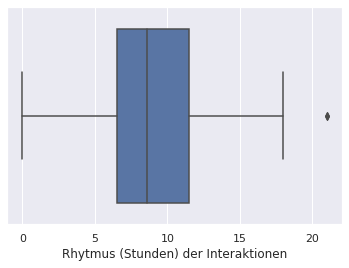

In [14]:
bp = sns.boxplot(x = df_members["mean_interval_hours"])
ret = bp.set_xlabel("Rhytmus (Stunden) der Interaktionen")

Die durschnittliche Anzahl bisher getätigter Interaktionen pro User beträgt ca. 4.

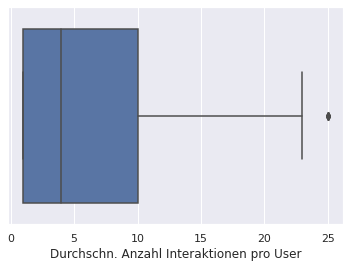

In [15]:
bp = sns.boxplot(x = df_members["interactions"])
ret = bp.set_xlabel("Durchschn. Anzahl Interaktionen pro User")

Man sieht hier ein paar Ausreißer, also User, die ihre erste Interaktion sehr viel länger, nachdem ihr Account aktiviert war, getätigt haben. Ansonsten erfolgte die erste Interaktion relativ zeitnah, nach ca. 15 Tagen im Mediain.

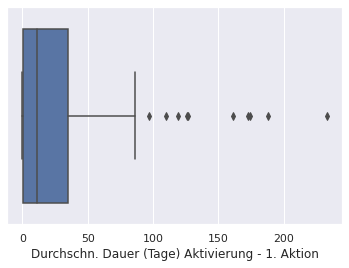

In [16]:
df_active_members = df_members[df_members.account_claim_time.notna()]
mask = df_active_members["account_claim_time"].map(pd.Timestamp) > pd.Timestamp(since_time, unit="s")
df_active_since = df_active_members.loc[mask, :]

bp = sns.boxplot(x = df_active_since["diff_claim_1st"])
ret = bp.set_xlabel("Durchschn. Dauer (Tage) Aktivierung - 1. Aktion")

Hier wurden einfach alle Interaktionen der User zu den jeweiligen Uhrzeiten (abgerundet auf die volle Stunde) gezählt. 9 und 10 Uhr scheinen am aktivsten zu sein.

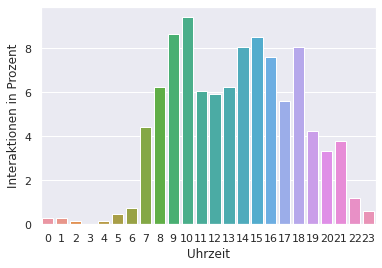

In [17]:
nparr = np.array(list(hours_activity.values()))
nparr = nparr / np.sum(nparr) * 100
ax = sns.barplot(x = list(hours_activity.keys()), y = nparr)
ax.set_xlabel("Uhrzeit")
ret = ax.set_ylabel("Interaktionen in Prozent")

## Gruppenaktivität

Hier wird pro Gruppe die Anzahl der Mitglieder erfasst und dargstellt. Zur Veranschaulichung der Aktivität werden Events, Dokumente, Dateien und Posts pro Gruppe zusammengezählt.
Betrachtet werden offene und geschlossene Gruppen. "Workplace for Good Community", die große multi-company-Gruppe, wird ausgelassen.  
<span style="color:red">Hinweis:</span>  
Es konnten leider nicht alle Interaktionen in der jeweiligen Gruppen gezählt werden aufgrund unklarer Fehler auf Serverseite. Die eigentliche Anzahl an Interaktionen fällt vermutlich noch um einiges höher aus.

In [18]:

df_groupnames = pd.DataFrame(get_all_pages("/company/groups", {'access_token': api_token}))
df_groupnames = df_groupnames[(df_groupnames.privacy == "OPEN") | (df_groupnames.privacy == "CLOSED")].reset_index(drop=True)

all_g_members = []
all_total_interact = []
g_names = []

for ix in df_groupnames.index:
    g_id = df_groupnames.loc[ix, "id"]
    g_names.append(df_groupnames.loc[ix, "name"])
    
    all_g_members.append(len(get_all_pages("/{}/members".format(g_id), 
                                           {'access_token': api_token, "fields" : "id"})))
    
    params = {'access_token': api_token, "since" : since_time}
    
    edge_interact = []
    for edge in ["feed", "events", "docs", "files", "albums"]:
        try:
            edge_interact.append( len(get_all_pages("/{}/{}".format(g_id, edge), params)) )
        except requests.exceptions.HTTPError:
             pass
    
    all_total_interact.append(np.sum(edge_interact))

Gruppennummer und -name:

In [19]:
pd.Series(g_names[:-1])

0     REDEZEIT FÜR DICH #virtualsupporttalks
1                                Reisegruppe
2                            Gaumenschmausen
3                                Musikzimmer
4                                 Lebensraum
5                         Gute Unterhaltung!
6                           Speakers' Corner
7                        Neue Medien & Hilfe
8                                Gesundheit!
9                           Sprachcafé FR 🇫🇷
10                          Sprachcafé EN 🇬🇧
11                                  Leseecke
12                            Raum der Kunst
13                          Sprachcafé ES 🇪🇸
14                          Sprachcafé IT 🇮🇹
15                                 Kränzchen
16                   Die eigenleben-Projekte
17                              Eigenlebende
dtype: object

Die Mitgliederzahl verteilt sich ziemlich gleichmäßig auf die alle Gruppen. Nur die Gruppen "REDEZEIT FÜR DICH #virtualsupporttalks" (0) und Kränzchen (15) den weit größten Abstand nach unten, gefolgt von "Sprachcafé ES" (13). Die Anzahl an Interaktionen ist wenig überraschend in der Hauptgruppe "Eigenlebende" am größten, und ebenfalls nur gering in den Gruppen 0 und 15. Ingesamt verteilt sich die Aktivität bzw. das Interesse also gut.

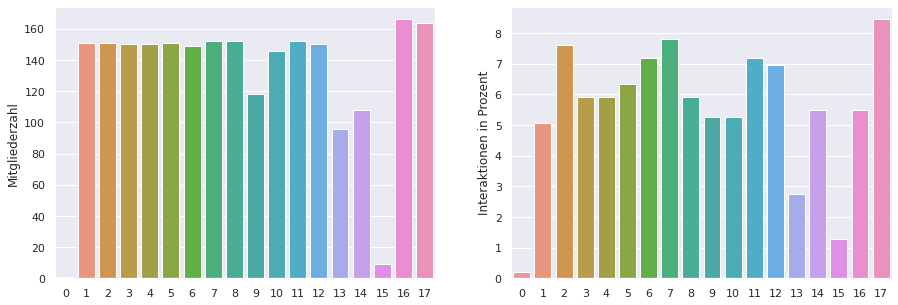

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].set_ylabel("Mitgliederzahl", fontsize = 12.0)
ax[1].set_ylabel("Interaktionen in Prozent", fontsize = 12.0)

sns.barplot(x = list(range(len(all_g_members) - 1)), y = all_g_members[:-1], ax=ax[0])

interact_percent = np.array(all_total_interact[:-1]) / np.sum(all_total_interact[:-1]) * 100

ret = sns.barplot(x = list(range(len(all_total_interact) - 1)), y = interact_percent, ax=ax[1])

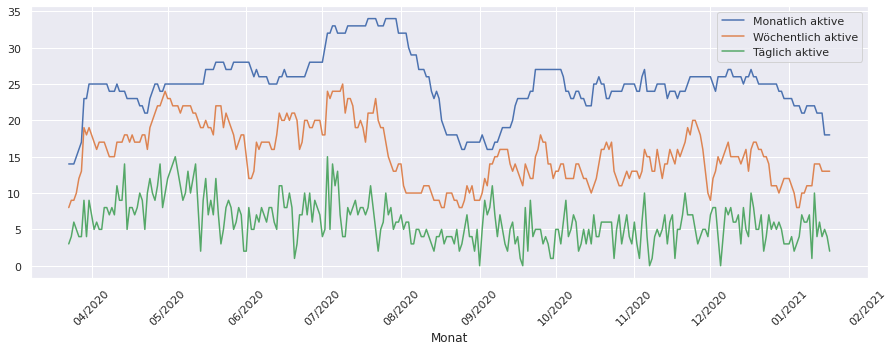

In [21]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
setupAxis(ax)
sns.lineplot(data=df_groups, ax=ax)

for line in ax.lines:
    line.set_linestyle("-")

for line in ax.legend().get_lines():
    line.set_linestyle('-')

ax.set_ylabel("")
ax.set_xlabel("Monat")
ret = plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

## Inhalte und Interaktion

Man sieht, dass die Interaktionen zum großen Teil in Form von Nachrichten stattfinden, was eine persönlichere Verbindung der User bedeutet als über Posts oder andere Interaktionen. Danach folgen Reaktionen.

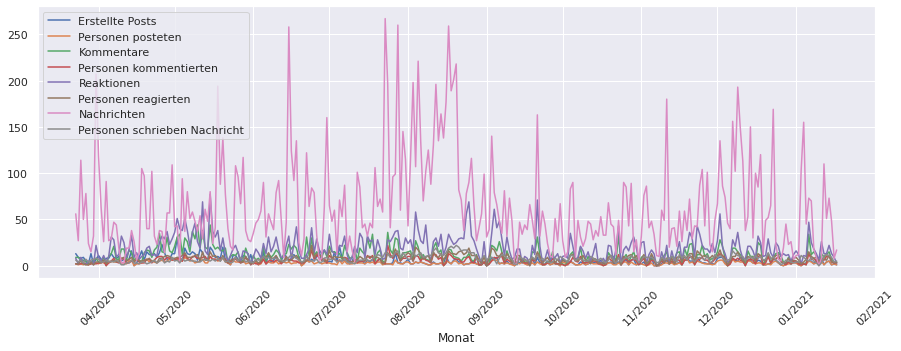

In [22]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
setupAxis(ax)

sns.lineplot(data=df_content, ax=ax)

for line in ax.lines:
    line.set_linestyle("-")

for line in ax.legend().get_lines():
    line.set_linestyle('-')

ax.set_ylabel("")
ax.set_xlabel("Monat")
ret = plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

Der Graph zählt als Summe die Verbindungen (Connections), die Eigenleben definiert als:

> * Post on a timeline  
* Reaction to a post  
* Comment on a post  
* Private message  
* Post view

Es ist zu sehen, dass sie, bis auf eine kurze sehr intensive Periode während oder nach dem Eigenleben-Sommerfest Ende August / Anfang September, mit wenig Abweichung um ca. 14 herum schwanken. Das heißt, es ist davon auszugehen, dass der Austausch bei Eigenleben durch Offline-Events stark gefördert ist.

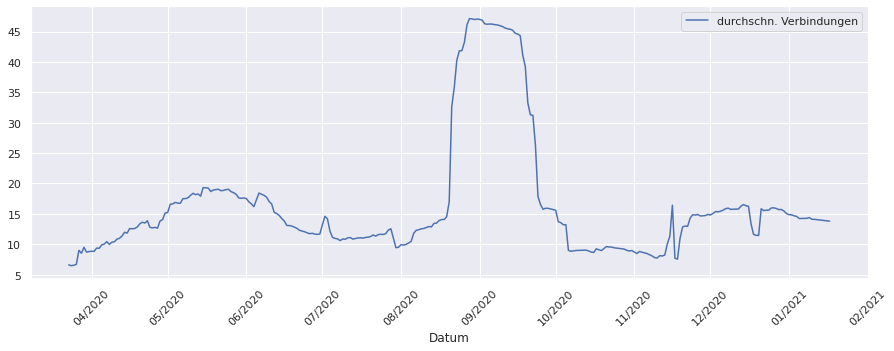

In [23]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
setupAxis(ax)


sns.lineplot(data=df_connections, ax=ax)

ax.set_ylabel("")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)


In [24]:
df_connections.describe()

,durchschn. Verbindungen
count,298.000000
mean,16.476719
std,10.059443
min,6.473684
25%,10.981250
50%,13.860606
75%,16.619420
max,47.129496
